See README.md for installs, environment setup

In [1]:
import sys
from multiprocessing import Pool

import numpy as np
import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# https://www.cvxpy.org/install/index.html
import cvxpy as cp

np.random.seed(2347)

print("%-20s %s" % ('python', ".".join(map(str, sys.version_info[:3]))))
print("%-20s %s" % ("numpy", np.__version__))
print("%-20s %s" % ("pandas", pd.__version__))
print("%-20s %s" % ("pandas-datareader", pdr.__version__))
print("%-20s %s" % ("seaborn", sns.__version__))
print("%-20s %s" % ("matplotlib", matplotlib.__version__))
print("%-20s %s" % ("cvxpy", cp.__version__))


/Users/drucev/opt/anaconda3/envs/portfolio_opt/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


python               3.7.7
numpy                1.18.1
pandas               1.0.3
pandas-datareader    0.8.1
seaborn              0.10.1
matplotlib           3.1.3
cvxpy                1.0.31


### 1. Get data

In [2]:
# load spreadsheet on Damodaran website into pandas dataframe
data_xls = 'http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
data_sheet = "Returns by year"
# these will change as rows get added on Damodaran website
skiprows = range(17)
skipfooter = 10
download_df = pd.read_excel('http://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls', 
                         sheet_name=data_sheet, 
                         skiprows=skiprows,
                         skipfooter=skipfooter)

In [3]:
download_df

,Year,S&P 500 (includes dividends),3-month T.Bill,US T. Bond,Baa Corporate Bond,S&P 500 (includes dividends)3,3-month T.Bill4,US T. Bond5,Baa Corporate Bond6,Stocks - Bills,Stocks - Bonds,Stocks - Baa Corp Bond,Historical risk premium,Inflation Rate,S&P 500 (includes dividends)2,3-month T. Bill (Real),!0-year T.Bonds,Baa Corp Bonds
0,1928,0.438112,0.030800,0.008355,0.032196,143.811155,103.080000,100.835471,103.219551,0.407312,0.429757,0.405916,NaN,-0.011522,0.454874,0.042815,0.020108,0.044227
1,1929,-0.082979,0.031600,0.042038,0.030179,131.877782,106.337328,105.074397,106.334569,-0.114579,-0.125018,-0.113158,NaN,0.000000,-0.082979,0.031600,0.042038,0.030179
2,1930,-0.251236,0.045500,0.045409,0.005398,98.745288,111.175676,109.845753,106.908543,-0.296736,-0.296646,-0.256634,NaN,-0.026712,-0.230686,0.074194,0.074101,0.032991
3,1931,-0.438375,0.023100,-0.025589,-0.156808,55.457774,113.743835,107.034958,90.144455,-0.461475,-0.412787,-0.281568,NaN,-0.089321,-0.383290,0.123448,0.069984,-0.074106
4,1932,-0.086424,0.010700,0.087903,0.235896,50.664911,114.960894,116.443660,111.409173,-0.097124,-0.174327,-0.322320,NaN,-0.103014,0.018495,0.126773,0.212842,0.377832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,2015,0.013789,0.000525,0.012843,-0.006975,294115.792218,1984.403234,7061.887631,35838.083510,0.013264,0.000946,0.020764,0.045434,0.001186,0.012588,-0.000661,0.011643,-0.008152
88,2016,0.117731,0.003175,0.006906,0.103651,328742.282302,1990.703714,7110.653529,39552.738791,0.114556,0.110825,0.014080,0.046177,0.012616,0.103805,-0.009323,-0.005639,0.089901
89,2017,0.216055,0.009308,0.028017,0.097239,399768.635072,2009.233848,7309.873866,43398.808328,0.206746,0.188038,0.118816,0.047687,0.021301,0.190692,-0.011743,0.006576,0.074354
90,2018,-0.042269,0.019392,-0.000167,-0.027626,382870.937409,2048.196241,7308.653674,42199.860601,-0.061660,-0.042102,-0.014642,0.046609,0.024426,-0.065104,-0.004914,-0.024006,-0.050811


In [4]:
# load gold data from FRED API & save copy locally to CSV file

series = ['GOLDAMGBD228NLBM']

gold_download = pdr.data.DataReader(series, 
                                    'fred', 
                                    start='1968-12-31')
# convert daily to annual
gold_download = gold_download.resample('A').last().reset_index()
gold_download.set_index(pd.DatetimeIndex(gold_download['DATE']).year, inplace=True)
gold_download['return'] = gold_download['GOLDAMGBD228NLBM'].pct_change()
gold_download.to_csv('gold_fred.csv')


In [5]:
# splice older gold data from other sources (Ibbotson yearbook)
longrun_data = pd.DataFrame({'year': list(range(1928, 2020)), 'gold': [0,0,0,0,0,0.563618771,0.082920792,0,0,0,0,0,-0.014285714,0.028985507,0,0.028169014,-0.006849315,0.027586207,0.026845638,0.124183007,-0.023255814,-0.035714286,-0.00617284,-0.00621118,-0.0325,-0.082687339,-0.007042254,-0.002836879,0.001422475,0.001420455,0,0,0.035460993,-0.02739726,-0.004225352,-0.002828854,0.002836879,0.004243281,-0.002816901,0.002824859,0.225352113,-0.057471264,-0.051219512,0.146529563,0.431390135,0.667919799,0.725864012,-0.242041683,-0.03962955,0.204305898,0.291744258,1.205670351,0.296078431,-0.327618087,0.1175,-0.149888143,-0.189473684,0.061688312,0.195412844,0.244563827,-0.156937307,-0.022308911,-0.036907731,-0.085577421,-0.057057907,0.176426426,-0.021697511,0.009784736,-0.046511628,-0.222086721,0.005748128,0.005368895,-0.060637382,0.014120668,0.23960217,0.217359592,0.04397843,0.17768595,0.231968811,0.319224684,0.043178411,0.250359299,0.292413793,0.089292067,0.082625735,-0.273303167,0.00124533,-0.114238,0.091174,0.118540,-0.011454,0.188312]})
longrun_data.set_index('year', inplace=True)
longrun_data.loc[1969:, 'gold'] = gold_download['return']
longrun_data


,gold
year,
1928,0.000000
1929,0.000000
1930,0.000000
1931,0.000000
1932,0.000000
...,...
2015,-0.114238
2016,0.091174
2017,0.118540


In [6]:
# make a dataframe of asset returns
df = download_df[["Year"]]
df['CPI'] = download_df['Inflation Rate']
df["T-Bills"] = download_df["3-month T. Bill (Real)"]
df["T-Notes"] = download_df["!0-year T.Bonds"]
df["Baa Corps"] = download_df["Baa Corp Bonds"]
df["S&P"] = download_df["S&P 500 (includes dividends)2"]
df.set_index('Year', inplace=True)
df["Gold"] = longrun_data['gold'] - df['CPI']


/Users/drucev/opt/anaconda3/envs/portfolio_opt/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/drucev/opt/anaconda3/envs/portfolio_opt/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/drucev/opt/anaconda3/envs/portfolio_opt/lib/python3.7/site-packages/ipykernel_launcher.py:5: Se

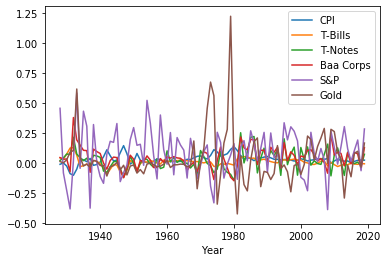

In [7]:
# plot
df.plot.line()


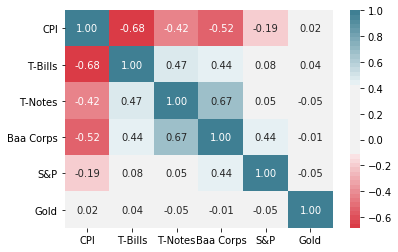

In [8]:
# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


### 2. Long-only optimization

In [9]:
# drop CPI which is not an asset
df.drop(labels=['CPI'], axis=1, inplace=True)
# drop T-Notes, allocations are small, favors corps 
# df.drop(labels=['T-Notes'], axis=1, inplace=True)
labels = list(df.columns)
labels


/Users/drucev/opt/anaconda3/envs/portfolio_opt/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


['T-Bills', 'T-Notes', 'Baa Corps', 'S&P', 'Gold']

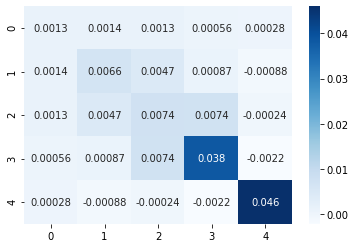

In [10]:
# compute covariance matrix
Sigma = np.cov(df.transpose())
sns.heatmap(Sigma, annot=True, cmap="Blues");


In [11]:
# number of assets
n = Sigma.shape[0]
# average returns
mu = df.mean().values
# asset STDs
asset_vols = np.sqrt(Sigma.diagonal())
# variable to optimize over - portfolio weights
w = cp.Variable(n)

# objectives to optimize
# portfolio return
ret = mu.T*w 
# volatility
vol = cp.quad_form(w, Sigma)


In [12]:
# Solve max return portfolio (corner solution)
prob = cp.Problem(cp.Maximize(ret), 
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
print("%-12s" % "Weights", dict(zip(labels, wts)))
print("%-12s" % "Real Return", '%.6f' % ret.value)
print("%-12s" % "Variance", '%.6f' % vol.value)
print("%-12s" % "STD", '%.6f' % np.sqrt(vol.value))
maxret = ret.value
maxretvol = vol.value

Weights      {'T-Bills': 0.0, 'T-Notes': 0.0, 'Baa Corps': 0.0, 'S&P': 1.0, 'Gold': 0.0}
Real Return  0.084127
Variance     0.038492
STD          0.196194


In [13]:
# solve min vol portfolio (other corner solution)
prob = cp.Problem(cp.Minimize(vol),
                  [cp.sum(w) == 1, 
                   w >= 0]
                 )
prob.solve()
wts = [float('%0.4f' % v) for v in w.value]
print("%-12s" % "Weights", dict(zip(labels, wts)))
print("%-12s" % "Real Return", '%.6f' % ret.value)
print("%-12s" % "Variance", '%.6f' % vol.value)
print("%-12s" % "STD", '%.6f' % np.sqrt(vol.value))

minvol = vol.value
minvolret = ret.value


Weights      {'T-Bills': 0.9584, 'T-Notes': -0.0, 'Baa Corps': -0.0, 'S&P': 0.0195, 'Gold': 0.0221}
Real Return  0.006584
Variance     0.001241
STD          0.035227


In [14]:
%%time
# solve points in between
# maximize return subject to volatility constraints between minimum volatility and max return volatility

# specify a Parameter variable instead of creating new Problem at each iteration
# this allows the solver to reuse previous work
vol_limit = cp.Parameter(nonneg=True)

prob = cp.Problem(cp.Maximize(ret),
                  [cp.sum(w) == 1, 
                   w >= 0,
                   vol <= vol_limit
                  ]
                 )

# define function so we can solve many in parallel
def solve_vl(vl_val):
    vol_limit.value = vl_val
    result = prob.solve()
    return (ret.value, np.sqrt(vol.value), w.value)

# number of points on the frontier
NPOINTS = 200
vl_vals = np.linspace(minvol, maxretvol, NPOINTS)

# iterate in-process
# results_dict = {}
# for vl_val in vl_vals:
#     results_dict[vl_val] = solve_vl(vl_val)
    
# parallel implementation
NPROCESSES = 8
pool = Pool(processes = NPROCESSES)
result_values = pool.map(solve_vl, vl_vals)
results_dict = dict(zip(vl_vals, result_values))


CPU times: user 15.3 ms, sys: 20.8 ms, total: 36.1 ms
Wall time: 266 ms


In [15]:
ret_df = pd.DataFrame(enumerate(results_dict.keys()))
ret_df.columns=['i', 'vol']
ret_df
ret_df['return'] = [results_dict[v][0] for v in ret_df['vol']]
ret_df['std'] = [results_dict[v][1] for v in ret_df['vol']]
for i, colname in enumerate(labels):
    ret_df[colname]=[results_dict[v][2][i] for v in ret_df['vol']]
    

In [16]:
ret_df


,i,vol,return,std,T-Bills,T-Notes,Baa Corps,S&P,Gold
0,0,0.001241,0.006589,0.035227,9.582865e-01,2.025989e-07,7.498197e-08,0.019592,2.212160e-02
1,1,0.001428,0.013485,0.037790,8.000160e-01,3.362386e-02,6.347475e-02,0.060858,4.202695e-02
2,2,0.001615,0.016599,0.040191,7.272852e-01,3.989620e-02,1.090606e-01,0.073846,4.991165e-02
3,3,0.001802,0.019004,0.042456,6.711318e-01,4.469729e-02,1.442994e-01,0.083870,5.600162e-02
4,4,0.001990,0.021037,0.044606,6.236290e-01,4.883879e-02,1.740314e-01,0.092348,6.115316e-02
...,...,...,...,...,...,...,...,...,...
195,195,0.037743,0.083675,0.194276,9.619357e-09,1.908183e-08,7.293244e-08,0.990703,9.296947e-03
196,196,0.037930,0.083789,0.194757,8.659669e-09,1.711175e-08,6.446349e-08,0.993045,6.954726e-03
197,197,0.038118,0.083902,0.195237,1.996769e-08,3.936636e-08,1.460280e-07,0.995375,4.624524e-03
198,198,0.038305,0.084015,0.195716,3.939064e-09,7.563910e-09,2.453631e-08,0.997694,2.306441e-03


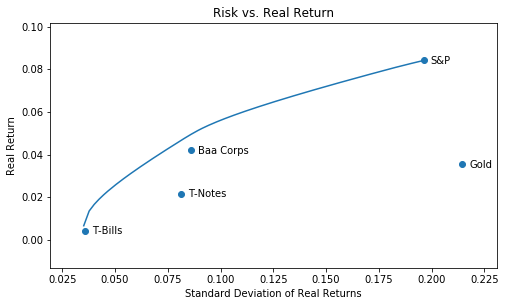

In [17]:
# plot frontier
plt.figure(figsize=(8, 4.5))
plt.scatter(asset_vols, mu)

x = ret_df['std']
y = ret_df['return']
plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")
plt.title("Risk vs. Real Return")

# plot the data
plt.plot(x,y)


xoffset = 0.0033
yoffset = 0.002
for i, label in enumerate(labels):
    plt.annotate(label, xy=(asset_vols[i]+xoffset, mu[i]+yoffset),  xycoords='data',
                horizontalalignment='left', verticalalignment='top',
               )


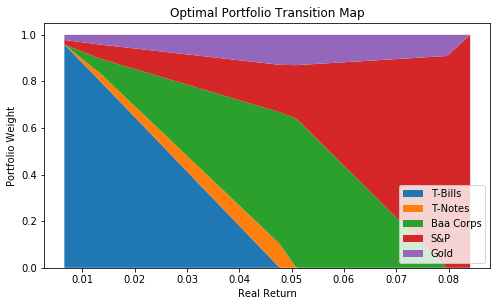

In [18]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights

x = ret_df['return']
y_list = [ret_df[l] for l in labels]

plt.figure(figsize=(8, 4.5))
plt.stackplot(x, y_list, labels=labels)
plt.legend(loc='lower right')
plt.xlabel("Real Return")
plt.ylabel("Portfolio Weight")
plt.title("Optimal Portfolio Transition Map");


### 3. Long/short optimization with leverage constraint

### 4. Factors